In [1]:
import torch
import scanpy as sc
import anndata as ad
import scDiffusion as sd


/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
DATA_PATH = 'data/'
OUTPUT_PATH = 'outputs/'

# Load dataset

We privide a testing dataset, BMMC, for data integration task. The BMMC dataset comes from Luecken, M.D. et al. A sandbox for prediction and integration of DNA, RNA, and proteins in single cells. Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2) (2021). The original dataset came from 12 healthy human donors. We selected cells from 4 donors to build the BMMC dataset. Download the testing dataset from Google drive: https://drive.google.com/drive/folders/1l2CFg368I_H6ghzfyrX1WNkUeAvcUENm?usp=share_link.

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'bmmc.h5ad')
adata

AnnData object with n_obs × n_vars = 29748 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

# Preprocess

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


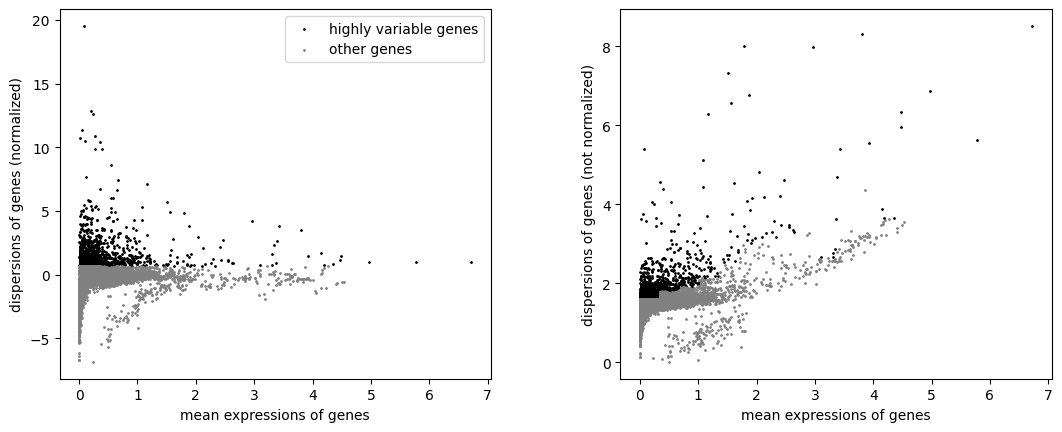

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [6]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 29748 × 2000
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [7]:
sd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], 
                   D_decode_list=[50, 300, 2000], 
                   max_epoch=2000, 
                   lr=1e-3, 
                   device=device)


2024-10-17 11:22:24,748 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2024-10-17 11:22:25,949 - ------------------------> Epoch: 1/2000, Current loss: 19007020.0000
2024-10-17 11:22:28,379 - ------------------------> Epoch: 51/2000, Current loss: 7070201.5000
2024-10-17 11:22:30,810 - ------------------------> Epoch: 101/2000, Current loss: 6423037.5000
2024-10-17 11:22:33,240 - ------------------------> Epoch: 151/2000, Current loss: 6120953.0000
2024-10-17 11:22:35,662 - ------------------------> Epoch: 201/2000, Current loss: 5946653.0000
2024-10-17 11:22:38,075 - ------------------------> Epoch: 251/2000, Current loss: 5844661

## view feature encoded embeddings

In [8]:
sc.pp.neighbors(adata, use_rep='X_fae', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


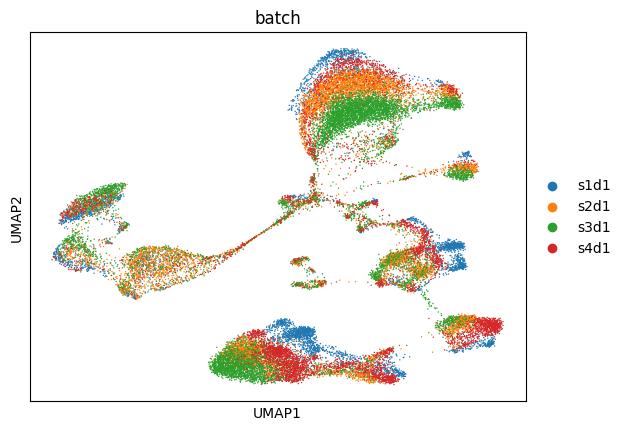

In [9]:
sc.pl.umap(adata, color=['batch'])

# Integration

In [10]:
# Due to high memory demands, consider using 'cpu' as a fallback if 'cuda' runs out of memory. 
# Although 'cpu' execution is slower, it can handle the task more efficiently in such cases and 
# typically completes in a few minutes.

sd.inte.evaluate_batch_isolation(adata, 
                            batch_key='batch', 
                            use_rep = 'X_fae',
                            device=device)

In [11]:
sd.inte.build_integration_graph(adata, use_rep='X_fae', n_edges_per_node=50, device=device)

In [12]:
sd.inte.build_integration_loss_adj(adata, use_rep='X_fae', k=50, device=device)

In [13]:
sd.inte.integration_diffusion(adata, 
                              use_rep='X_fae',
                              max_epoch=2000, 
                              lr=1e-3, 
                              time_increment_diffusion=0.2,
                              device=device)


2024-10-17 11:26:55,068 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/sc_integration/integration_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2024-10-17 11:26:55,458 - ------------------------> Epoch: 1/2000, Current loss: 9683816448.0000
2024-10-17 11:27:13,988 - ------------------------> Epoch: 51/2000, Current loss: 203043008.0000
2024-10-17 11:27:32,504 - ------------------------> Epoch: 101/2000, Current loss: 177284128.0000
2024-10-17 11:27:51,020 - ------------------------> Epoch: 151/2000, Current loss: 172841760.0000
2024-10-17 11:28:09,555 - ------------------------> Epoch: 201/2000, Current loss: 170901888.0000
2024-10-17 11:28:28,091 - ------------------------> Epoch: 251/2000, Cu

## View integrated embeddings

In [14]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

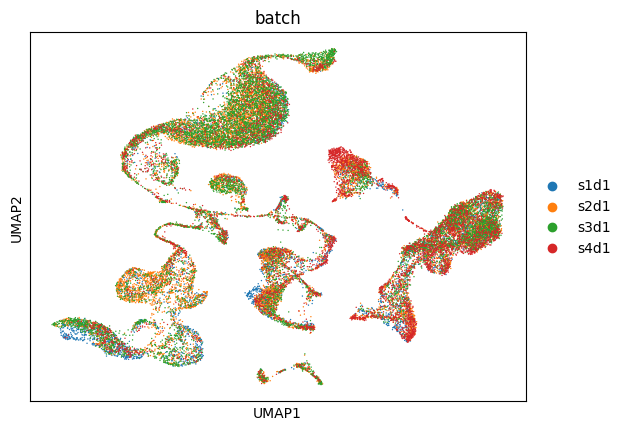

In [15]:
sc.pl.umap(adata, color=['batch'])

# Save integrated data

In [16]:
adata.write(OUTPUT_PATH+'integrated_adata.h5ad')

In [17]:
adata = ad.read_h5ad(OUTPUT_PATH+'integrated_adata.h5ad')

# Clustering

After data integration, we can directly carry out the clustering (and trajectory inference) process.

In [18]:
sd.graph.build_graph(adata, use_rep="X_dif", k=50, device=device)
sd.graph.call_attention(adata, device=device)

In [19]:
sd.anal.att_leiden(adata, resolution=0.2)

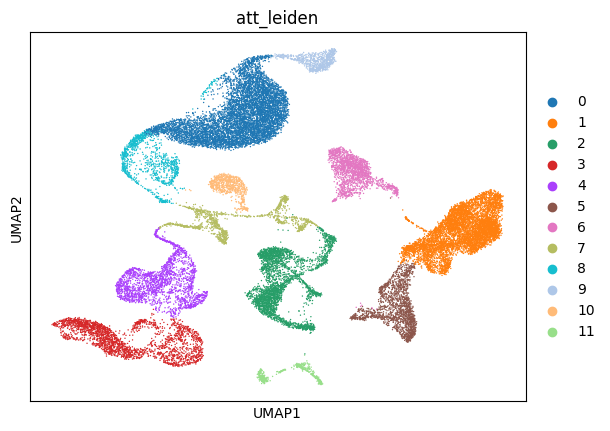

In [20]:
sc.pl.umap(adata, color=['att_leiden'])